In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
from sklearn.metrics import roc_auc_score
from scipy.special import softmax

from CLoNe.clone import CLoNe
from theme import colors

In [2]:
# parameters
p_thr = 0.5
pdc = 2
n_resize = 4

# grid search
# for all predicted frames
results = []
for filepath in tqdm(glob("outputs/*_u*.npz")):
    # extract pdbid and mdid from basename
    pdbid, mdid = os.path.basename(filepath).split('.')[0].split('_')

    # debug print
    #print(pdbid, mdid)

    # load data
    P = np.load(filepath)['P']
    t = np.load(filepath)['t']
    Xp = np.load(filepath)['Xp']
    y = np.load(filepath)['y']

    # compute auc
    auc = np.array([roc_auc_score(y, p) for p in P])
    #print(f"mean auc = {np.mean(auc):.3f}")

    # weighted centers
    #Xc = np.sum(Xp * np.expand_dims(P,2), axis=1) / np.sum(np.expand_dims(P,2),axis=1)
    #m = np.ones(Xc.shape[0], dtype=bool)
    T = (P > p_thr).astype(np.float32)
    m = (np.sum(T, axis=1) > 0.0)
    Xc = np.sum(Xp[m] * np.expand_dims(T[m],2), axis=1) / np.sum(np.expand_dims(T[m],2),axis=1)

    # weighted distance standard deviations
    #s = np.sqrt(np.sum(np.sum(np.square(Xp - np.expand_dims(Xc,1)) * np.expand_dims(P,2), axis=2), axis=1) / np.sum(P, axis=1))

    # clustering
    clone = CLoNe(pdc=pdc, n_resize=n_resize, filt=0.1)
    clone.fit(Xc)
    ids_c = clone.centers
    #print(len(ids_c), ids_c)

    Xy = np.sum(Xp * y.reshape(1,-1,1), axis=1) / np.sum(y.reshape(1,-1,1),axis=1)

    ids_clst = []
    for i in range(len(ids_c)):
        ids_clst.append(np.where(clone.labels_ == i)[0])

    # plot
    #fig = plt.figure(figsize=(9,9))
    #ax = fig.add_subplot(projection='3d')
    #for ids in ids_clst:
    #    ax.scatter(Xc[ids,0], Xc[ids,1], Xc[ids,2], marker='.')
    #ax.set_xlim(Xp[:,0].min(), Xp[:,0].max())
    #ax.set_ylim(Xp[:,1].min(), Xp[:,1].max())
    #ax.set_zlim(Xp[:,2].min(), Xp[:,2].max())
    #ax.scatter(Xc[ids_c,0], Xc[ids_c,1], Xc[ids_c,2], marker='s', color='k')
    #ax.scatter(Xy[:,0], Xy[:,1], Xy[:,2], marker='.', color='k')
    #ax.view_init(30, 210)
    #plt.show()

    for i, ids in enumerate(ids_clst):
        # additional prediction informations
        p_int = P[m][ids_c[i]][P[m][ids_c[i]] > p_thr]
        X_int = Xp[m][ids_c[i]][P[m][ids_c[i]] > p_thr]
        r_int = np.sqrt(np.mean(np.sum(np.square(X_int - np.mean(X_int, axis=0).reshape(1,-1)), axis=1)))

        # store results
        results.append({
            "pdbid": pdbid,
            "mdid": mdid,
            "cid": i,
            "clust_center_auc": auc[m][ids_c[i]],
            "mean_clust_auc": np.mean(auc[m][ids]),
            "clust_size": len(ids),
            "starting_auc": auc[0],
            "mean_auc": np.mean(auc),
            "mean_int_p": np.mean(p_int),
            "std_int_p": np.std(p_int),
            "max_int_p": np.max(p_int),
            "r_int": r_int,
            "int_size": p_int.shape[0],
        })

    # display debug
    #display(pd.DataFrame(results[-len(ids_c):]))

# build dataframe
df = pd.DataFrame(results)
dfs = df.groupby(by=["pdbid", "mdid"]).max()[['clust_center_auc','starting_auc','mean_auc','cid']].sort_values('starting_auc')

# debug print summary results
r = (dfs['clust_center_auc'].values > dfs['starting_auc'].values).mean()
nm_clust = dfs['cid'].mean()
d_auc = np.mean(dfs['clust_center_auc'].values - dfs['starting_auc'].values)
print("p_thr = {:.2f}, pdc = {:.1f}, n_resize = {:.1f}, r = {:.3f}, mn_clust = {:.1f}, d_auc = {:.2f}".format(p_thr, pdc, n_resize, r, nm_clust, d_auc))

  2%|█                                           | 1/40 [00:00<00:12,  3.02it/s]/home/khaos/syncfolder/phd/projects/pesto/md_analysis/CLoNe/clone.py:95: RuntimeWarning: divide by zero encountered in true_divide
  inv_dc = 1 / dc
/home/khaos/syncfolder/phd/projects/pesto/md_analysis/CLoNe/clone.py:100: RuntimeWarning: invalid value encountered in multiply
  ordered_knn_dens = np.exp(-1 * np.square(knn_dist * inv_dc))
 15%|██████▌                                     | 6/40 [00:01<00:10,  3.18it/s]/home/khaos/syncfolder/phd/projects/pesto/md_analysis/CLoNe/clone.py:237: RuntimeWarning: invalid value encountered in true_divide
  c2_0 /= np.sum(c2_0)
/home/khaos/syncfolder/phd/projects/pesto/md_analysis/CLoNe/clone.py:236: RuntimeWarning: invalid value encountered in true_divide
  c2_1 /= np.sum(c2_1)
 38%|████████████████▏                          | 15/40 [00:04<00:07,  3.16it/s]/home/khaos/syncfolder/phd/projects/pesto/md_analysis/CLoNe/clone.py:95: RuntimeWarning: divide by zero encounte

p_thr = 0.50, pdc = 2.0, n_resize = 4.0, r = 0.850, mn_clust = 12.7, d_auc = 0.11


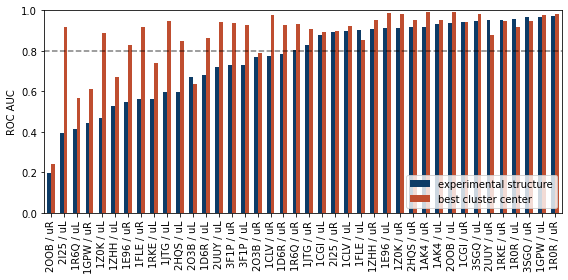

In [17]:
# set colors
colors = ['#0e9595', '#0d3b66', '#bf4e30']

# plot data
dfs = df.groupby(by=["pdbid", "mdid"]).max()[['clust_center_auc','starting_auc','mean_auc','cid']]
dfs['d_auc'] = dfs['clust_center_auc'] - dfs['starting_auc']
dfs = dfs.sort_values('starting_auc')
#dfs = dfs.sort_values('d_auc')
#dfs = dfs.sort_values('clust_center_auc')
y0 = dfs['starting_auc'].values
y1 = dfs['clust_center_auc'].values
x = np.arange(y0.shape[0])
labels = np.array([' / '.join(k) for k in dfs.index.values])

# plot
plt.figure(figsize=(8,4))
plt.bar(x-0.15, y0, width=0.3, color=colors[1], label="experimental structure")
plt.bar(x+0.15, y1, width=0.3, color=colors[2], label="best cluster center")
plt.plot([-0.5, len(x)-0.5], [0.8, 0.8], 'k--', alpha=0.5)
plt.xticks(x, labels, rotation=90)
plt.xlim(-0.5, len(x)-0.5)
plt.ylim(0.0, 1.0)
plt.legend(loc='lower right')
plt.ylabel('ROC AUC')
plt.tight_layout()
plt.savefig("graphs/clustering_unbound.png", dpi=150)
plt.savefig("graphs/clustering_unbound.svg", dpi=150)
plt.show()

In [4]:
33 / 40, 21 / 40

(0.825, 0.525)

In [5]:
"{} / {}".format(((dfs['starting_auc'] < 0.8) & (dfs['clust_center_auc'] > 0.8)).sum(), (dfs['starting_auc'] < 0.8).sum())

'12 / 19'

In [6]:
"{} / {}".format(((dfs['starting_auc'] > 0.8) & (dfs['clust_center_auc'] > 0.8)).sum(), (dfs['starting_auc'] > 0.8).sum())

'21 / 21'

In [7]:
"{} / {}".format((dfs['clust_center_auc'] > 0.8).sum(), dfs.shape[0])

'33 / 40'

In [8]:
"{} / {}".format((dfs['starting_auc'] > 0.8).sum(), dfs.shape[0])

'21 / 40'

In [9]:
dfs['starting_auc'].mean(), dfs['starting_auc'].median()

(0.7624295400750426, 0.8165862891645559)

In [10]:
dfs['clust_center_auc'].mean(), dfs['clust_center_auc'].median()

(0.8744482170205353, 0.923538838612368)

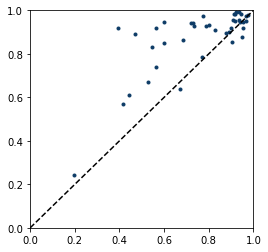

In [11]:
plt.figure(figsize=(4,4))
plt.plot(y0, y1, '.', color=colors[1])
plt.plot([0.0, 1.0], [0.0, 1.0], 'k--')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.show()

In [12]:
# load starting rmsd for structures
dfr = pd.read_csv("summary_md.csv")
dfr = dfr[dfr['mdid'].isin(['uR', 'uL'])]
dfr = dfr[['pdbid', 'mdid', 'rmsd']]

# merging dataframes
dfa = pd.merge(dfs, dfr, on=['pdbid', 'mdid'])

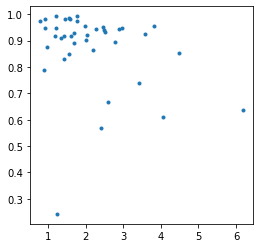

In [13]:
x = dfa['rmsd'].values
y = dfa['clust_center_auc'].values

plt.figure(figsize=(4,4))
plt.plot(x,y,'.')
plt.show()

In [14]:
dfs.sort_values('d_auc', ascending=False)

,,clust_center_auc,starting_auc,mean_auc,cid,d_auc
pdbid,mdid,,,,,
2I25,uL,0.916667,0.394048,0.551060,44,0.522619
1Z0K,uL,0.889016,0.469108,0.780546,5,0.419908
1FLE,uR,0.918801,0.563005,0.561832,18,0.355795
1JTG,uL,0.946366,0.597870,0.759185,28,0.348496
1E96,uR,0.830971,0.547838,0.658804,19,0.283133
2HQS,uL,0.848293,0.598049,0.692525,10,0.250244
2UUY,uL,0.942350,0.720621,0.532787,15,0.221729
3F1P,uR,0.940235,0.729412,0.850353,13,0.210824
1CLV,uR,0.975025,0.773128,0.902254,15,0.201896
